In [17]:
print("hello world")

hello world


In [76]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset
import random
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

In [79]:

class SegmentationTransforms:
    def __init__(self, image_size=(256, 256), degrees=15, scale=(0.8, 1.2), shear=10, contrast_range=(0.5, 1.0)):
        self.image_size = image_size
        self.degrees = degrees
        self.scale = scale
        self.shear = shear
        self.contrast_range = contrast_range  # new param for contrast factor range

    def __call__(self, image, mask):
        # Horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Vertical flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random affine transform
        angle = random.uniform(-self.degrees, self.degrees)
        translations = (0, 0)
        scale = random.uniform(self.scale[0], self.scale[1])
        shear = random.uniform(-self.shear, self.shear)
        image = TF.affine(image, angle=angle, translate=translations, scale=scale, shear=shear, fill=0)
        mask = TF.affine(mask, angle=angle, translate=translations, scale=scale, shear=shear, fill=0, interpolation=TF.InterpolationMode.NEAREST)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=self.image_size)
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Color jitter on image
        color_jitter = transforms.ColorJitter(0.2, 0.2, 0.2, 0.05)
        image = color_jitter(image)

        # Random contrast adjustment (factor between contrast_range)
        contrast_factor = random.uniform(self.contrast_range[0], self.contrast_range[1])
        image = TF.adjust_contrast(image, contrast_factor)

        # Optional: Gaussian blur on image only
        if random.random() > 0.7:
            image = TF.gaussian_blur(image, kernel_size=3)

        # Resize both to image_size
        image = TF.resize(image, self.image_size)
        mask = TF.resize(mask, self.image_size, interpolation=TF.InterpolationMode.NEAREST)

        return image, mask

In [80]:
# Instantiate transform
augmentor = SegmentationTransforms(image_size=(256, 256))

#Paths
image_path = "src\dataset\images\Grain 1.png"
mask_path = "src\dataset\masks\Grain 1.png"

# Load your image and mask (both must be PIL Images)
image = Image.open(image_path).convert('L')
mask = Image.open(mask_path).convert('L')

# Instantiate and apply transform
augmentor = SegmentationTransforms(image_size=(256, 256))
aug_image, aug_mask = augmentor(image, mask)

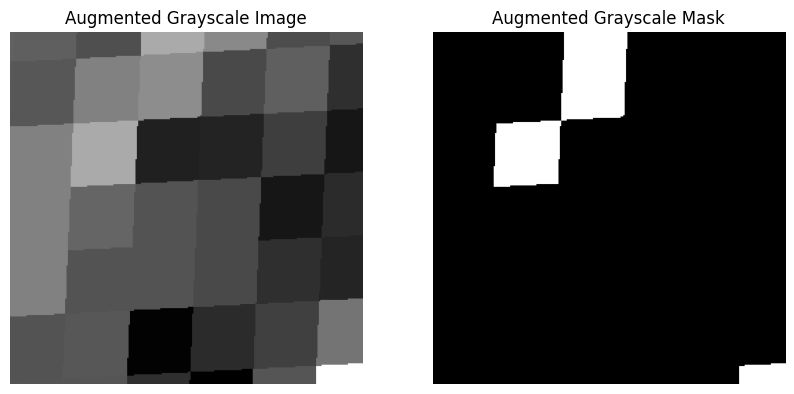

In [81]:
# Show results
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(aug_image, cmap='gray')
ax[0].set_title('Augmented Grayscale Image')
ax[0].axis('off')

ax[1].imshow(aug_mask, cmap='gray')
ax[1].set_title('Augmented Grayscale Mask')
ax[1].axis('off')

plt.show()

In [82]:
def augment_dataset(src_img_dir, src_mask_dir, dst_img_dir, dst_mask_dir, augmentor, augmentations_per_image=5):
    os.makedirs(dst_img_dir, exist_ok=True)
    os.makedirs(dst_mask_dir, exist_ok=True)

    img_filenames = [f for f in os.listdir(src_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    for img_name in img_filenames:
        img_path = os.path.join(src_img_dir, img_name)
        mask_path = os.path.join(src_mask_dir, img_name)  # assuming masks have same filename

        if not os.path.exists(mask_path):
            print(f"Mask for image {img_name} not found, skipping.")
            continue

        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        for i in range(augmentations_per_image):
            aug_image, aug_mask = augmentor(image, mask)

            base_name, ext = os.path.splitext(img_name)
            aug_img_name = f"{base_name}_aug_{i+1}{ext}"

            aug_image.save(os.path.join(dst_img_dir, aug_img_name))
            aug_mask.save(os.path.join(dst_mask_dir, aug_img_name))

        print(f"Augmented {img_name} with {augmentations_per_image} samples.")

In [83]:
src_images = "src/dataset/images"
src_masks = "src/dataset/masks"
dst_images = "src/dataset_aug/images"
dst_masks = "src/dataset_aug/masks"
augmentations_per_image = 5  # adjust this as you want

augmentor = SegmentationTransforms(image_size=(256, 256))
augment_dataset(src_images, src_masks, dst_images, dst_masks, augmentor, augmentations_per_image)

Augmented Grain 1.png with 5 samples.
Augmented Grain 102.png with 5 samples.
Mask for image Grain 106.png not found, skipping.
Augmented Grain 114.png with 5 samples.
Augmented Grain 13.png with 5 samples.
Augmented Grain 17.png with 5 samples.
Augmented Grain 18.png with 5 samples.
Augmented Grain 2.png with 5 samples.
Augmented Grain 25.png with 5 samples.
Augmented Grain 3.png with 5 samples.
Augmented Grain 33.png with 5 samples.
Augmented Grain 35.png with 5 samples.
Augmented Grain 5.png with 5 samples.
Augmented Grain 6.png with 5 samples.
Augmented Grain 7.png with 5 samples.
Augmented Grain 76.png with 5 samples.
Augmented Grain 78.png with 5 samples.
Augmented Grain 79.png with 5 samples.
Augmented Grain 8.png with 5 samples.
